### Package installation 

In [2]:
! sudo apt install -y fluidsynth
! pip install --upgrade pyfluidsynth
! pip install pretty_midi 
! pip install keras_self_attention

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Conecting to my google drive 

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Importing Libraries

In [46]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from music21 import *

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

import pickle
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import time
import os
from itertools import groupby
import mido
from mido import MidiFile, merge_tracks, tempo2bpm
import math
import random

from keras.preprocessing import sequence
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D, Activation, GlobalMaxPooling2D
from keras_self_attention import SeqSelfAttention
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Layer
from tensorflow.python.client import device_lib
import keras

### Parameters

In [54]:
### CHANGE THE PATH WITH YOUR OWN FOLDERS ###
encoded_data_path = "drive/MyDrive/Colab Notebooks/npy_chopin_2"
data_path = pathlib.Path('drive/MyDrive/Colab Notebooks/midi_chopin_format_0_dataset_full/midi_chopin_format_0_dataset_full')
filenames = glob.glob(str(data_path/"*.mid"))


seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

batch_size = 32
sequence_length = 100 #600
generate_sample_every_ep = 100

maxlen = sequence_length  # Max sequence size
# embed_dim = 128  # Embedding size for each token
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads
feed_forward_dim = 128  # Hidden layer size in feed forward network inside transformer

# vocab_size = 50000
vocab_size = 40000
unk_tag_str = ''
unk_tag_idx = 0
pad_tag_str = ''
pad_tag_idx = 1

### Exploration

In [6]:
print('Number of files:', len(filenames))

Number of files: 139


In [7]:
filenames[1]

'drive/MyDrive/Colab Notebooks/midi_chopin_format_0_dataset_full/midi_chopin_format_0_dataset_full/chopin_mazurkas_6_3_(c)lubetsky.mid'

### First-step-Preprocessing : RUN THIS ONLY ONCE 😉
It will create/save .npy files locally corresponding to piano roll

In [16]:
def extract_midi_info(path):
    mid = converter.parse(path)
    max_idx = np.argmax(len(i) for i in mid)
    piano_part = mid[max_idx] #probably

    for i in piano_part:
        if isinstance(i, tempo.MetronomeMark):
            bpm = i.getQuarterBPM()
            break

    key = piano_part.keySignature

    if key is None:
      key = piano_part.analyze('key')

    key_in_major = key.asKey(mode='major')
    offset_by = key_in_major.tonic.pitchClass
    
    return offset_by, bpm

In [18]:
def preprocess_midi(path, offset_by, bpm):
    mid = pretty_midi.PrettyMIDI(midi_file=path)
    filtered_inst_ls = [inst for inst in mid.instruments if ((len(inst.notes) > 0) and
                                                    (inst.is_drum == False) and
                                                    (inst.program < 8)
                                                   )]
    piano = filtered_inst_ls[np.argmax([len(inst.notes) for inst in filtered_inst_ls])]
            
    start_time = piano.notes[0].start
    end_time = piano.get_end_time()
    
    quater_note_len = 60/bpm
#   Set 4 for 16th note, 8 for 32nd note
    nth_note = 8
    fs = 1/(quater_note_len/nth_note)
    
    piano_roll = piano.get_piano_roll(fs = fs, times = np.arange(start_time, end_time,1./fs))
#   Normalise key signature
    piano_roll = np.roll(piano_roll, -offset_by)
#   Set all velocity to 1
    out = np.where(piano_roll > 0, 1,0)
    
    return out.T

In [19]:
failed_list = []
succeed_list = []
# keep track of list of midi we failed to parse and preprocess
for temp in filenames:
    try:
        offset_by, bpm = extract_midi_info(temp)
        piano_roll = preprocess_midi(temp, offset_by, bpm)
        name  = temp.split("/")[-1].split(".")[0]
        out_name = encoded_data_path + f'/encoded_{name}.npy'
        np.save(out_name, piano_roll)
        succeed_list.append(out_name)
        print(f"saved {out_name}")
        
    except:
        print(f"Failed to preprocess {temp}")
        failed_list.append(temp)
        continue

saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_mazurkas_7_4_(c)lubetsky.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_mazurkas_6_3_(c)lubetsky.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chpn_op23.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_64833a_nocturne_op_32_no_1_b_major_(nc)smythe.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chpn_op7_1.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_mazurkas_59_2_(c)lubetsky.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_mazurkas_56_1_(c)lubetsky.npy


/usr/local/lib/python3.8/dist-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_sonata_58_4_(c)finley.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_valse_70_3_(c)simonetto.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chpn-p19.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_mazurkas_24_4_(c)lubetsky.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chpn_op7_2.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_mazurkas_68_2_(c)lubetsky.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_fantasie_49_(c)lubetsky.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_etude_nouvelles_1_(c)unknown.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_58486a_nocturne_op_55_no_1_(nc)smythe.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_51116a_scherzo_3_39_(c)smythe.npy
saved drive/MyDrive/Colab Notebooks/npy_chopin_2/encoded_chopin_mazurkas_17_2_(c)lubetsky.npy
saved drive/MyDrive/Colab Not

In [21]:
len(failed_list), len(succeed_list)

(0, 139)

### Function to display the audio

In [22]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [25]:
display_audio(pretty_midi.PrettyMIDI(filenames[50]))

### 🏔 Creating the model structure

In [132]:
from keras import layers 
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
#         self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.maxlen = maxlen
        self.maximum_position_encoding = 10000
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            'maxlen': self.maxlen,
        })
        return config
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
        
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        pos_encoding = self.positional_encoding(self.maximum_position_encoding, self.embed_dim)
        x = self.token_emb(x)
        return x + pos_encoding[:,:maxlen,:]

In [133]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        #defining no of nodes/dim for each layer
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
        })
        return config

    @staticmethod
    def causal_attention_mask(n_dest, n_src, dtype):
        """
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        return tf.cast(m, dtype)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)

        # prevent information flow from future tokens
        shape = tf.shape(scaled_score)
        dim_dest, dim_src = shape[2], shape[3]
        attention_mask = self.causal_attention_mask(
            dim_dest, dim_src, scaled_score.dtype
        )
        attention_mask = tf.reshape(attention_mask, [1, 1, dim_dest, dim_src])
        scaled_score = scaled_score * attention_mask - 1e4 * (1 - attention_mask)

        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [134]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def call(self, inputs):
        attention_output = self.att(inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [135]:
train_loss = []
val_loss = []
def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block1 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    transformer_block2 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    transformer_block3 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    x = transformer_block1(x)
    x = transformer_block2(x)
    x = transformer_block3(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

In [136]:
model = create_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddin  (None, 100, 128)         5120000   
 g_8 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_24 (Trans  (None, 100, 128)         99584     
 formerBlock)                                                    
                                                                 
 transformer_block_25 (Trans  (None, 100, 128)         99584     
 formerBlock)                                                    
                                                                 
 transformer_block_26 (Trans  (None, 100, 128)         9958

### Downoload your .npy piano roll files created locally
Verify that you have the same number of .npy than .mid 😁




In [149]:
npy_data_path = pathlib.Path('drive/MyDrive/Colab Notebooks/npy_chopin_2')

#### THE DATA USED TO TOKENISE ####
npy_filenames = glob.glob(str(npy_data_path/'*.npy'))

In [104]:
print('Number of npy files:', len(npy_filenames))

Number of npy files: 139


### Tokenizing the MIDI files
takes a bit of time 😄

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([np.arange(128).tolist()])

all_songs = []
# all_song_in_tuple = []
all_songs_np = np.empty((0,128), np.int8)
for temp in npy_filenames :
    encoded_data = np.load(temp).astype(np.int8)
    all_songs.append(encoded_data)
#   append all songs into one array
    all_songs_np = np.append(all_songs_np, encoded_data, axis=0)

unique_np, counts = np.unique(all_songs_np, axis=0, return_counts=True)
# convert binary array into multi label index tuple e.g([1 0 0 1] --> (0,3) )
unique_note_intergerized = np.array(mlb.inverse_transform(unique_np))
count_sort_ind = np.argsort(-counts)

vocab = unique_note_intergerized[count_sort_ind][:vocab_size-2].tolist()
top_counts = counts[count_sort_ind][:vocab_size-1].tolist()

vocab.sort(key=len)
vocab.insert(unk_tag_idx, unk_tag_str)
vocab.insert(pad_tag_idx, pad_tag_str)
vocab_size = len(vocab)
# vocab_size = 54000
print(f"vocab size: {len(vocab)}")
print(f"vocab first 5 words: {vocab[:5]}")


combi_to_int = dict((combi, number) for number, combi in enumerate(vocab))
int_to_combi = dict((number, combi) for number, combi in enumerate(vocab))

all_song_tokenised = []
for idx, song in enumerate(all_songs):
    print(f"processing song number {idx}")
    song = mlb.inverse_transform(song)
    song = [combi_to_int[tup] if tup in vocab else unk_tag_idx for tup in song]
#     song = [combi_to_int[tup] for tup in song]
    all_song_tokenised.append(np.array(song))
print(f"Completed tokenising all song")

In [105]:
# should equal len(filenames)
len(all_song_tokenised)

139

### Creating generator 

In [137]:
class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, all_song_tokenised, batch_size, sequence_length, shuffle=True) :
        self.all_song_tokenised = all_song_tokenised
        self.pad_tag_idx = 1
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.val_split = 0.2
        self.on_epoch_end()
    
    def __len__(self) :
        return int(np.ceil(len(self.all_song_tokenised)/ self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.all_song_tokenised)
  
    def __getitem__(self, idx) :
        batch_x = np.empty((0, self.sequence_length), float)
        batch_y = np.empty((0, self.sequence_length), float)
        for i in range(self.batch_size):
            if(idx*self.batch_size + i == len(self.all_song_tokenised)-1):
                return batch_x, batch_y
            song = self.all_song_tokenised[idx*self.batch_size + i]
            start_idx = random.randint(0,len(song) - self.sequence_length/2)
            seq = song[start_idx: start_idx + self.sequence_length + 1]
            x= seq[:-1]
            y = seq[1:]
#           padding if needed
            if(len(y) < self.sequence_length):
                no_of_pad = self.sequence_length - len(y)
                x = np.append(x, [self.pad_tag_idx]*no_of_pad, axis = 0)
                y = np.append(y, [self.pad_tag_idx]*no_of_pad, axis = 0)
            
            batch_x = np.append(batch_x, [x], axis = 0)
            batch_y = np.append(batch_y, [y], axis = 0)
            
        return batch_x, batch_y

In [138]:
class GeneratorCallback(keras.callbacks.Callback):
    """Callback to generate text from trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for next token
    3. Sample next token and add it to the next input

    # Arguments
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, top_k=10, print_every=5
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
#         self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            x = start_tokens[-sequence_length:]
            pad_len = maxlen - len(start_tokens)
            sample_index = -1
            if pad_len > 0:
                x = start_tokens + [0] * pad_len
                sample_index = len(start_tokens) - 1
            
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
            
#         txt = " ".join(
#             [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
#         )

        print(f"last 40 tokens of starting token:\n{self.start_tokens[-50:]}\n")
        print(f"generated token:\n{tokens_generated}\n")

start_tokens = all_song_tokenised[1][:sequence_length-200]
num_tokens_generated = 80
gen_callback = GeneratorCallback(num_tokens_generated, start_tokens, print_every= generate_sample_every_ep)


### TRAIN the model 

In [147]:
#### PARAMS ####
epochs = 4000
batchsize = 32
sequence_length = 100 #600
output_path = f"./output/"
my_training_batch_generator = My_Custom_Generator(all_song_tokenised, batchsize, sequence_length)

In [ ]:
#### Train the model ####
if not os.path.exists(output_path):
    os.mkdir(output_path)

weight_path = output_path + "music-gen-weight.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    weight_path,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint,gen_callback]
history = model.fit(x = my_training_batch_generator,
                    callbacks = callbacks_list,                    
                   epochs = epochs,
                   verbose = 1)

train_loss += history.history['loss']

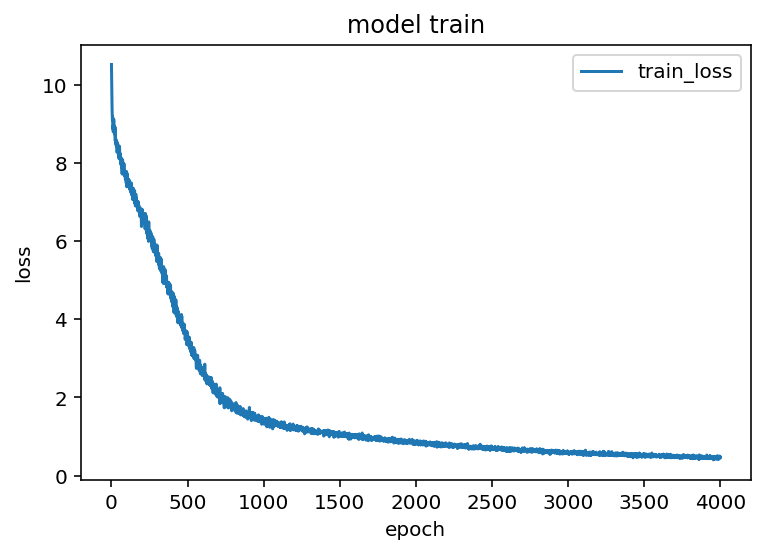

Result stored in ./output/


In [148]:
#### Show the loss evolution ####
plt.plot(train_loss)
plt.title('model train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss'], loc='upper right')
plt.savefig(output_path + 'loss.png')
plt.show()
print("Result stored in {}".format(output_path))

### Generate your output MIDI file.
mid_out = generetaed piece starting with 10sec chopin's original music

In [146]:

seed_len = 100
num_note_to_gen = 1000

# We get a random sequence from the input
# if we want to choose the song : manally type the song_idx
song_idx = random.randint(0,len(all_song_tokenised)-1)
seq_start_at = random.randint(0,len(all_song_tokenised[song_idx])-sequence_length)   
start_tokens = all_song_tokenised[song_idx][seq_start_at:seq_start_at + seed_len].tolist()

original = start_tokens.copy()
backup = original.copy()

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def sample_from(logits, k):
    logits, indices = tf.math.top_k(logits, k= k, sorted=True)
    indices = np.asarray(indices).astype("int32")
    preds = np.asarray(logits).astype("float32")
    if(unk_tag_idx in indices):
        unk_tag_position = np.where(indices == unk_tag_idx)[0].item()
        indices = np.delete(indices, unk_tag_position)
        preds = np.delete(preds, unk_tag_position)
    preds = softmax(preds)
    return np.random.choice(indices, p=preds)

def convertToRoll(seq_list):
    seq_list = [int_to_combi[i] for i in seq_list]
    roll = mlb.transform(seq_list)
    print(seq_list)
    return roll


k = 10
tokens_generated = []
num_tokens_generated = 0

while num_tokens_generated <= num_note_to_gen:
    x = start_tokens[-sequence_length:]
    pad_len = maxlen - len(start_tokens)
    sample_index = -1
    if pad_len > 0:
        x = start_tokens + [0] * pad_len
        sample_index = len(start_tokens) - 1
    
    x = np.array([x])
    y, _ = model.predict(x)
    sample_token = sample_from(y[0][sample_index],10) 
    tokens_generated.append(sample_token)
    start_tokens.append(sample_token)
    num_tokens_generated = len(tokens_generated)
    print(f"generated {num_tokens_generated} notes")
    
# print(f"Piano int seq generated")
piano_roll = convertToRoll(start_tokens)
print("-------------------------------------------")
original = convertToRoll(original)

1/1 [==============================] - 0s 24ms/step
generated 1 notes
1/1 [==============================] - 0s 22ms/step
generated 2 notes
1/1 [==============================] - 0s 22ms/step
generated 3 notes
1/1 [==============================] - 0s 24ms/step
generated 4 notes
1/1 [==============================] - 0s 25ms/step
generated 5 notes
1/1 [==============================] - 0s 23ms/step
generated 6 notes
1/1 [==============================] - 0s 20ms/step
generated 7 notes
1/1 [==============================] - 0s 21ms/step
generated 8 notes
1/1 [==============================] - 0s 23ms/step
generated 9 notes
1/1 [==============================] - 0s 23ms/step
generated 10 notes
1/1 [==============================] - 0s 24ms/step
generated 11 notes
1/1 [==============================] - 0s 22ms/step
generated 12 notes
1/1 [==============================] - 0s 23ms/step
generated 13 notes
1/1 [==============================] - 0s 23ms/step
generated 14 notes
1/1 [==========

In [141]:
def piano_roll_to_pretty_midi(piano_roll_in, fs, program=0, velocity = 64):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    piano_roll = np.where(piano_roll_in == 1, 64, 0)
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI(initial_tempo=100.0)
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')
    print(piano_roll.shape)
    
    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [143]:
# here you can choose the tempo of the output. 150 works nice for me.
bpm = 150
fs = 1/((60/bpm)/4)

##### CHANGE THE NAME EVERY TIME YOU GENERATE DATA #####
name = "test_on_4000_ep"

# fs = 100
# ori = np.array(ori)
mid_out = piano_roll_to_pretty_midi(piano_roll.T, fs=fs)
mid_ori = piano_roll_to_pretty_midi(original.T, fs=fs)
midi_out_path = output_path+f"gpt-v3-id-{name}.mid"
if midi_out_path is not None:
        mid_out.write(midi_out_path)
        
midi_ori_path = output_path+f"ori-gpt-v3-id-{name}.mid"
if midi_ori_path is not None:
        mid_ori.write(midi_ori_path)

(128, 1103)
(128, 102)


In [115]:
display_audio(pretty_midi.PrettyMIDI('output/gpt-v3-id-test_on_5000_ep_v2.mid'))
#it works better when playing the midi file directly on the computer 

In [131]:
#This is not working for me but if you manage to get the music sheet that's cool :)
Stream = converter.parse('output/gpt-v3-id-test_on_5000_ep_v2.mid')
Stream.show()

SubConverterException: ignored